In [14]:
# import JAX to use
import jax
import jax.numpy as jnp
from jax import grad, vmap, random
from sklearn.datasets import fetch_openml
import pickle
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

1. Implement a dense feedforward neural network from scratch.

   The implementation must be flexible with respect to:
   - The input and output dimensions.
   - The number of hidden layers.
   - The number of neurons per hidden layer.
   - The activation functions used.

   This implementation will be used for the following two questions.

   Choose a suitable initialization for the network parameters.

In [15]:
# We start with a function that initializes the network parameters.
def init_net_params(layer_widths, key):
    """
    Initialize the network parameters.
    """
    params = []
    keys = random.split(key, len(layer_widths) - 1)

    for i, (n_in, n_out) in enumerate(zip(layer_widths[:-1], layer_widths[1:])):
        w_key = keys[i]
        scale = jnp.sqrt(2.0 / n_in) # xavier initialization
        w = random.normal(w_key, shape=(n_in, n_out)) * scale
        b = jnp.zeros((n_out,))
        params.append({'w': w, 'b': b})

    return params


In [16]:
# Next, we define a forward pass function that computes the output of the network for a given input.
def forward(params, x, activation):
    """
    Forward pass of the network.
    """

    activations = {
        'relu': jax.nn.relu,
        'sigmoid': jax.nn.sigmoid,
        'tanh': jax.nn.tanh,
        'softmax': jax.nn.softmax
    }
    activation = activations[activation]

    for layer in params[:-1]:
        x = x @ layer['w'] + layer['b']
        x = activation(x)

    # output layer, no activation function
    final_layer = params[-1]
    return jnp.dot(x, final_layer['w']) + final_layer['b']

def get_batches(x, y, batch_size=256):
    """
    Returns a list of tuples (x_batch, y_batch), each of size batch_size
    (last batch may be smaller).
    """
    n = x.shape[0]
    
    # Make key
    key = random.PRNGKey(0)
    perm = jax.random.permutation(key, n)
    x_shuffled = x[perm]
    y_shuffled = y[perm]

    batches = []
    for i in range(0, n, batch_size):
        x_batch = x_shuffled[i:i+batch_size]
        y_batch = y_shuffled[i:i+batch_size]
        batches.append((x_batch, y_batch))

    return batches

def get_splits(x, y, train=0.8):
    """
    This return a jax array of the training, validation, and test splits
    """
    n = x.shape[0]
    x = jnp.array(x) / 255.0 # normalize to [0,1]
    y = jnp.array(y)
    # Calculate split indices (as integers)
    train_end = int(train * n)
    test_end = train_end + int((1-train)) * n
    
    # Split the data
    x_train = x[:train_end]
    y_train = y[:train_end]
    
    x_test = x[test_end:]
    y_test = y[test_end:]
    
    return x_train, y_train, x_test, y_test

def get_kfolds(x, y, k=5):
    """
    Generate k-fold cross-validation splits.
    """
    n = x.shape[0]

    fold_size = n // k
    folds = []

    for i in range(k):
        # Validation fold indices
        val_start = i * fold_size
        val_end = (i + 1) * fold_size if i < k - 1 else n
        
        # Validation set
        x_val = x[val_start:val_end]
        y_val = y[val_start:val_end]
        
        # Training set (everything except validation fold)
        x_train = jnp.concatenate([x[:val_start], x[val_end:]], axis=0)
        y_train = jnp.concatenate([y[:val_start], y[val_end:]], axis=0)
        
        folds.append((x_train, y_train, x_val, y_val))
    
    return folds

In [17]:
# Next, we define the MSE loss function, we can have other loss functions
def mse_loss(params, x, y, activation):
    """
    MSE loss function for the network.
    """
    batched_forward = vmap(forward, in_axes=(None, 0, None))
    preds = batched_forward(params, x, activation)
    return jnp.mean((preds - y) ** 2)

def class_loss(params, x, y, activation):
    """
    Classification cross-entroy loss function
    """
    batched_forward = vmap(forward, in_axes=(None, 0, None))
    logits = batched_forward(params, x, activation)

    log_probs = jax.nn.log_softmax(logits, axis=1)
    
    nll = -log_probs[jnp.arange(y.shape[0]), y]
    loss = jnp.mean(nll)

    return loss

def evaluate_model(params, x, y, activation, classification):
    """
    Evaluate model on a dataset and return accuracy and loss.
    """
    batched_forward = vmap(forward, in_axes=(None, 0, None))
    logits = batched_forward(params, x, activation)

    if classification:
        preds = jnp.argmax(logits, axis=1)
        
        accuracy = jnp.mean(preds == y)
        loss = class_loss(params, x, y, activation)
        
        return accuracy, loss
    else:
        loss = jnp.mean((logits - y) ** 2)
        return loss, loss

In [18]:
# We now define an update function that updates the network parameters.
def update(params, x, y, activation, lr, classification):
    """
    Update function for the network parameters (basic gradient descent).
    """
    loss_fn = class_loss if classification else mse_loss
    grads = grad(loss_fn)(params, x, y, activation)
    new_params = jax.tree.map(lambda p, g: p - lr * g, params, grads)
    return new_params

# After training, save the parameters
def save_params(params, filename='assets/params.pkl'):
    """Save model parameters."""
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    with open(filename, 'wb') as f:
        pickle.dump(params, f)
    print(f"Parameters saved to {filename}")

def load_params(filename='assets/params.pkl'):
    """Load model parameters."""
    with open(filename, 'rb') as f:
        params = pickle.load(f)
    print(f"Parameters loaded from {filename}")
    return params

2. Consider a standard benchmark dataset for classification: train a neural network to classify handwritten digits into the ten classes 0, 1,..., 9. As input for your model, use flattened vector representations of the MNIST images

   (a) For this multiclass classification task, train your neural network with cross-entropy loss and mini-batch gradient descent. Vary the neural network architecture (layers, neurons per layer, activation functions) and training hyperparameters (learning rate, batch size, epochs). Use grid search with k-fold cross-validation (e.g., k = 5) to select promising hyperparameters. Report the accuracy and learning curves for the best model.

In [19]:
mnist = fetch_openml('mnist_784')
print(f"We have {mnist.data.shape[0]} images")
print(f"Each image has {mnist.data.shape[1]} pixels (features)")

We have 70000 images
Each image has 784 pixels (features)


In [20]:
def train_model_kfold(x_train, y_train, layer_widths, activation, lr, batch_size, epochs, k=5, classification=True):
    """
    Train the model using kfold cross-validation.
    """
    folds = get_kfolds(x_train, y_train, k=k)
    fold_results =[]
    learning_curves = []

    for fold_idx, (x_train_fold, y_train_fold, x_val_fold, y_val_fold) in enumerate(folds):
        key = random.PRNGKey(42 + fold_idx) # we use a different key for each fold
        params = init_net_params(layer_widths, key)

        fold_history = {
            'train_acc': [],
            'val_acc': [],
            'train_loss': [],
            'val_loss': []
        }

        for epoch in range(epochs):
            batches = get_batches(x_train_fold, y_train_fold, batch_size=batch_size)

            for x_batch, y_batch in batches:
                params = update(params, x_batch, y_batch, activation, lr, classification=classification)
            
            train_acc, train_loss = evaluate_model(params, x_train_fold, y_train_fold, activation, classification=classification)
            val_acc, val_loss = evaluate_model(params, x_val_fold, y_val_fold, activation, classification=classification)

            fold_history['train_acc'].append(float(train_acc))
            fold_history['val_acc'].append(float(val_acc))
            fold_history['train_loss'].append(float(train_loss))
            fold_history['val_loss'].append(float(val_loss))
            
            if epoch % 50 == 0:
                print(f"Fold {fold_idx+1}, Epoch {epoch}: Val Acc = {val_acc:.4f}, Val Loss = {val_loss:.4f}")
        
        final_train_acc, final_train_loss = evaluate_model(params, x_train_fold, y_train_fold, activation, classification=classification)
        final_val_acc, final_val_loss = evaluate_model(params, x_val_fold, y_val_fold, activation, classification=classification)

        fold_results.append((final_train_acc, final_val_acc, final_train_loss, final_val_loss))
        learning_curves.append(fold_history)
    
    mean_val_acc = np.mean([fold[1] for fold in fold_results])
    mean_val_loss = np.mean([fold[3] for fold in fold_results])
    
    return mean_val_acc, mean_val_loss, fold_results, learning_curves

def train_model(x_train, y_train, x_test, y_test, best_config, classification=True):
    """
    Train the best model on the full training set and evaluate on test set.
    """
    layer_widths = best_config['layer_widths']
    activation = best_config['activation']
    lr = best_config['learning_rate']
    batch_size = best_config['batch_size']
    epochs = best_config['epochs']
    
    print(f"\nTraining best model on full training set...")
    print(f"Configuration: {best_config}")
    
    # Initialize parameters
    key = random.PRNGKey(42)
    params = init_net_params(layer_widths, key)
    
    learning_curve = {
        'train_acc': [],
        'test_acc': [],
        'train_loss': [],
        'test_loss': []
    }
    
    # Training loop
    for epoch in range(epochs):
        batches = get_batches(x_train, y_train, batch_size=batch_size)
        
        for x_batch, y_batch in batches:
            params = update(params, x_batch, y_batch, activation, lr, classification=classification)
        
        # Evaluate periodically
        if epoch % 1 == 0 or epoch == epochs - 1:
            train_acc, train_loss = evaluate_model(params, x_train, y_train, activation, classification=classification)
            test_acc, test_loss = evaluate_model(params, x_test, y_test, activation, classification=classification)
            
            learning_curve['train_acc'].append(float(train_acc))
            learning_curve['test_acc'].append(float(test_acc))
            learning_curve['train_loss'].append(float(train_loss))
            learning_curve['test_loss'].append(float(test_loss))
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}: Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")
    
    # Final evaluation
    test_acc, test_loss = evaluate_model(params, x_test, y_test, activation, classification=classification)
    print(f"\nFinal Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"Final Test Loss: {test_loss:.4f}")
    
    return params, test_acc, test_loss, learning_curve

In [21]:
# Grid search configurations
grid_search_configs = {
    'architectures': [
        # 2 hidden layers
        [784, 128, 128, 10],
        [784, 512, 512, 10],
        
        # 3 hidden layers
        [784, 128, 128, 128, 10],
    ],
    
    # Activation functions
    'activations': ['relu'],
    
    # Learning rates
    'learning_rates': [0.001, 0.1],
    
    # Batch sizes
    'batch_sizes': [256, 1024],
    
    # Epochs
    'epochs': [100]
}

In [22]:
# We define the grid search function
def grid_search(x_train, y_train, configs, k=5, classification=True):
    """
    Perform grid search on the space of possible parameters defined earlier using k-fold cross validation
    
    """
    # Generate all combinations
    combinations = list(itertools.product(
        configs['architectures'],
        configs['activations'],
        configs['learning_rates'],
        configs['batch_sizes'],
        configs['epochs']
    ))

    total_combinations = len(combinations)
    print(f"Total configurations to test: {total_combinations}")
    print(f"With k={k} folds, total training runs: {total_combinations * k}")
    print("-" * 80)

    best_acc = -1
    best_loss = -1
    best_config = None
    best_learning_curves = None
    best_fold_results = None

    for idx, (layer_widths, activation, lr, batch_size, epochs) in enumerate(combinations):
        print(f"\n[{idx+1}/{total_combinations}] Testing configuration:")
        print(f"Architecture: {layer_widths}")
        print(f"Activation: {activation}")
        print(f"Learning Rate: {lr}")
        print(f"Batch Size: {batch_size}")
        print(f"Epochs: {epochs}")
        
        mean_val_acc, mean_val_loss, fold_results, learning_curves = train_model_kfold(
            x_train, y_train, layer_widths, activation, lr, batch_size, epochs, k=k, classification=classification
        )
        
        # result
        config = {
            'layer_widths': layer_widths,
            'activation': activation,
            'learning_rate': lr,
            'batch_size': batch_size,
            'epochs': epochs
        }
        
        print(f"Mean Validation Accuracy: {mean_val_acc:.4f} ({mean_val_acc*100:.2f}%)")
        print(f"Mean Validation Loss: {mean_val_loss:.4f}")
        
        # Update best configuration
        if mean_val_acc > best_acc:
            best_acc = mean_val_acc
            best_loss = mean_val_loss
            best_config = config.copy()
            best_learning_curves = learning_curves
            best_fold_results = fold_results
            print(f"New best configuration!")
    
    print("\n" + "=" * 80)
    print("Grid Search Complete!")
    print(f"Best Configuration:")
    print(f"Architecture: {best_config['layer_widths']}")
    print(f"Activation: {best_config['activation']}")
    print(f"Learning Rate: {best_config['learning_rate']}")
    print(f"Batch Size: {best_config['batch_size']}")
    print(f"Epochs: {best_config['epochs']}")
    print(f"Best Mean Validation Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")
    print("=" * 80)
    
    return best_config, best_acc, best_loss, best_learning_curves, best_fold_results

In [23]:
# Run to perform grid search
x = mnist.data.to_numpy()
y = mnist.target.astype(int).to_numpy()
x_train, y_train, x_test, y_test = get_splits(x, y)

# Run grid search to find best configs
best_config, best_acc, best_loss, best_learning_curves, best_fold_results = grid_search(
    x_train, y_train, 
    grid_search_configs, 
    k=5
)

print("The best configuration is:")
print(best_config)
print(f"Best K-fold Mean Accuracy: {best_acc:.2f} ({best_acc*100:.2f}%)")
print(f"Best K-fold Mean Loss: {best_loss:.2f}")

Total configurations to test: 12
With k=5 folds, total training runs: 60
--------------------------------------------------------------------------------

[1/12] Testing configuration:
Architecture: [784, 128, 128, 10]
Activation: relu
Learning Rate: 0.001
Batch Size: 256
Epochs: 100
Fold 1, Epoch 0: Val Acc = 0.2330, Val Loss = 2.1852


KeyboardInterrupt: 


Training best model on full training set...
Configuration: {'layer_widths': [784, 128, 128, 10], 'activation': 'relu', 'learning_rate': 0.01, 'batch_size': 256, 'epochs': 250}
Epoch 0: Train Acc = 0.7782, Test Acc = 0.8017
Epoch 10: Train Acc = 0.9198, Test Acc = 0.9283
Epoch 20: Train Acc = 0.9375, Test Acc = 0.9404
Epoch 30: Train Acc = 0.9478, Test Acc = 0.9489
Epoch 40: Train Acc = 0.9553, Test Acc = 0.9558
Epoch 50: Train Acc = 0.9610, Test Acc = 0.9598
Epoch 60: Train Acc = 0.9659, Test Acc = 0.9631
Epoch 70: Train Acc = 0.9700, Test Acc = 0.9649
Epoch 80: Train Acc = 0.9732, Test Acc = 0.9676
Epoch 90: Train Acc = 0.9757, Test Acc = 0.9701
Epoch 100: Train Acc = 0.9779, Test Acc = 0.9706
Epoch 110: Train Acc = 0.9797, Test Acc = 0.9711
Epoch 120: Train Acc = 0.9811, Test Acc = 0.9717
Epoch 130: Train Acc = 0.9829, Test Acc = 0.9728
Epoch 140: Train Acc = 0.9843, Test Acc = 0.9734
Epoch 150: Train Acc = 0.9857, Test Acc = 0.9740
Epoch 160: Train Acc = 0.9870, Test Acc = 0.9747
E

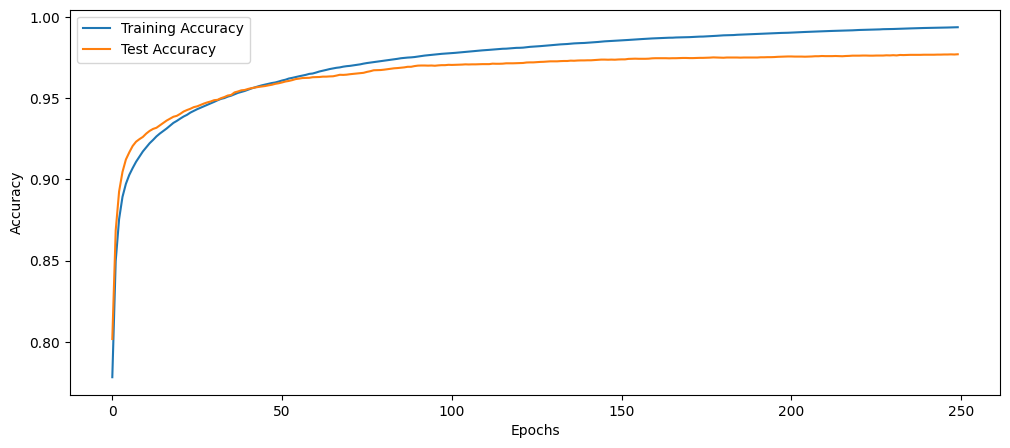

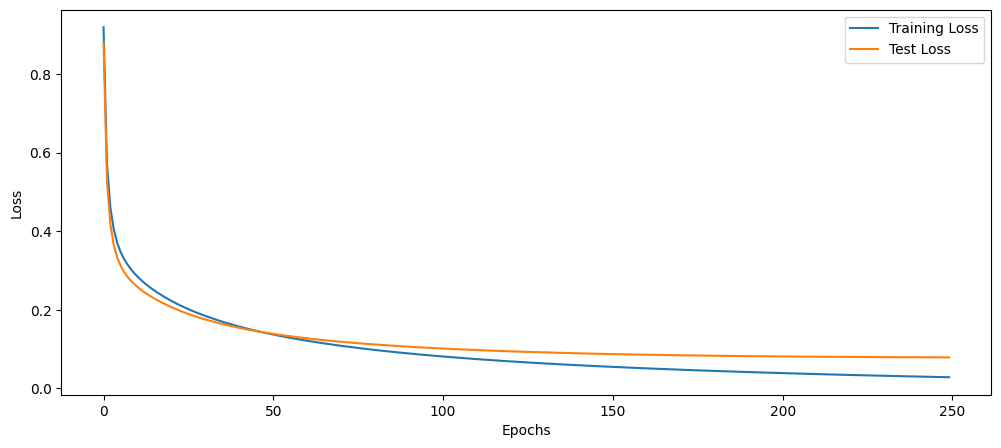

Parameters saved to ../assets/mnist_params.pkl


In [ ]:
# Train best model on the best params
best_config = {
    'layer_widths': [784, 128, 128, 10],
    'activation': 'relu',
    'learning_rate': 0.01,
    'batch_size': 256,
    'epochs': 250
}

params, test_acc, test_loss, learning_curve = train_model(
    x_train, y_train, x_test, y_test, best_config
)

print(f"Our best model trained on the full training set has an accuracy of {test_acc}%")
print(f"Our best model trained on the full training set has a loss of {test_loss:.2f}")

plt.figure(figsize=(12, 5))
plt.plot(learning_curve['train_acc'], label='Training Accuracy')
plt.plot(learning_curve['test_acc'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(learning_curve['train_loss'], label='Training Loss')
plt.plot(learning_curve['test_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

save_params(params, filename='../assets/mnist_params.pkl')

   (b) Study how optimizer hyperparameters (batch size, learning rate) affect convergence speed and final performance, and discuss your observations.


 (c) Identify and visualize misclassified images for your best model, and provide possible explanations.

Next, test the performance of your neural network implementation on a simple regression problem. Fit functions of the form

$$f_k(x) := \sin(k\pi x), \quad x \in [-1, 1],$$

with $k \in \mathbb{N}$ using your neural network implementation. Use mean squared error (MSE) as the loss. Generate a sufficient number of training samples yourself, balancing approximation quality and computational cost.


(a) Perform a grid search to find the best hyperparameters for fitting $f_1$, varying at least the parameters that you also tested in Question 2. Discuss your findings.



In [28]:
# Grid search configurations for regression
grid_search_configs = {
    'architectures': [
        # 2 hidden layers
        [1, 128, 128, 1],
        [1, 512, 512, 1],
        
        # 3 hidden layers
        [1, 128, 128, 128, 1],
    ],
    
    # Activation functions
    'activations': ['relu', 'tanh'],
    
    # Learning rates
    'learning_rates': [0.001, 0.1],
    
    # Batch sizes
    'batch_sizes': [256, 1024],
    
    # Epochs
    'epochs': [100]
}

In [24]:
# We start by generating a sufficient number of training samples. We will use 1000 samples.
n_samples = 100000
k = 1
x = jnp.linspace(-1, 1, n_samples).reshape(-1, 1)
y = jnp.sin(k * jnp.pi * x)

key = random.PRNGKey(42)
indices = jnp.arange(n_samples)
shuffled_indices = random.permutation(key, indices)

# Shuffle x and y such that we do not train on the left hand side only
x_shuffled = x[shuffled_indices]
y_shuffled = y[shuffled_indices]

x_train, y_train, x_test, y_test = get_splits(x, y)

In [29]:
# We do the same grid search as in Question 2.
best_config, best_acc, best_loss, best_learning_curves, best_fold_results = grid_search(
    x_train, y_train, 
    grid_search_configs, 
    k=5,
    classification=False
)

print("The best configuration is:")
print(best_config)
print(f"Best K-fold Mean Accuracy: {best_acc:.2f} ({best_acc*100:.2f}%)")
print(f"Best K-fold Mean Loss: {best_loss:.2f}")

Total configurations to test: 24
With k=5 folds, total training runs: 120
--------------------------------------------------------------------------------

[1/24] Testing configuration:
Architecture: [1, 128, 128, 1]
Activation: relu
Learning Rate: 0.001
Batch Size: 256
Epochs: 100
Fold 1, Epoch 0: Val Acc = 0.2277, Val Loss = 0.2277


KeyboardInterrupt: 


Training best model on full training set...
Configuration: {'layer_widths': [1, 32, 32, 1], 'activation': 'tanh', 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 250}
Epoch 0: Train Acc = 0.4894, Test Acc = 0.4758
Epoch 10: Train Acc = 0.3765, Test Acc = 0.1696
Epoch 20: Train Acc = 0.3454, Test Acc = 0.1506
Epoch 30: Train Acc = 0.3194, Test Acc = 0.1387
Epoch 40: Train Acc = 0.2969, Test Acc = 0.1315
Epoch 50: Train Acc = 0.2777, Test Acc = 0.1282
Epoch 60: Train Acc = 0.2614, Test Acc = 0.1280
Epoch 70: Train Acc = 0.2477, Test Acc = 0.1305
Epoch 80: Train Acc = 0.2359, Test Acc = 0.1357
Epoch 90: Train Acc = 0.2258, Test Acc = 0.1436
Epoch 100: Train Acc = 0.2167, Test Acc = 0.1548
Epoch 110: Train Acc = 0.2082, Test Acc = 0.1706
Epoch 120: Train Acc = 0.1998, Test Acc = 0.1940
Epoch 130: Train Acc = 0.1907, Test Acc = 0.2315
Epoch 140: Train Acc = 0.1800, Test Acc = 0.2931
Epoch 150: Train Acc = 0.1671, Test Acc = 0.3700
Epoch 160: Train Acc = 0.1568, Test Acc = 0.4397
Epoch 1

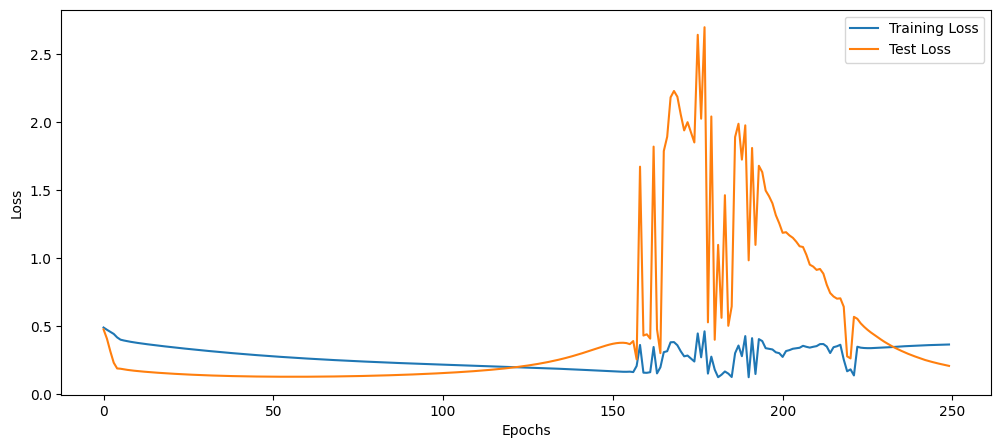

Parameters saved to ../assets/reg_params.pkl


In [26]:
# We now train the best model on the full training set.
best_config = {
    'layer_widths': [1, 32, 32, 1],
    'activation': 'tanh',
    'learning_rate': 0.01,
    'batch_size': 64,
    'epochs': 250
}

params, test_acc, test_loss, learning_curve = train_model(
    x_train, y_train, x_test, y_test, best_config, classification=False
)

plt.figure(figsize=(12, 5))
plt.plot(learning_curve['train_loss'], label='Training Loss')
plt.plot(learning_curve['test_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

save_params(params, filename='../assets/reg_params.pkl')

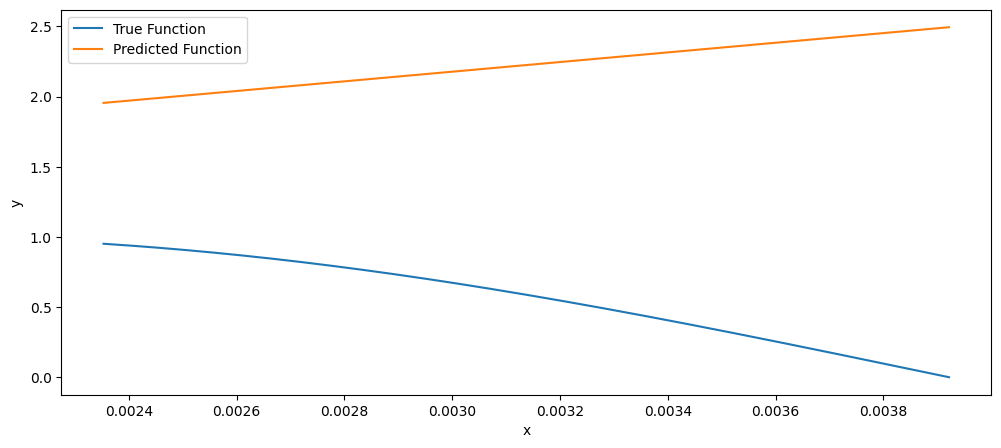

In [27]:
# plot the true function and the predicted function
y_pred = forward(params, x_test, 'relu')
plt.figure(figsize=(12, 5))
plt.plot(x_test, y_test, label='True Function')
plt.plot(x_test, y_pred, label='Predicted Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

(b) Try to fit $f_k$ for different values of $k$. How do you need to change the hyperparameters when increasing $k$? Discuss your findings. How far can you increase $k$?



(c) Finally, propose an approach to approximate $f_k$ with higher values of $k$ and test it. Examples could include different function spaces than neural networks, architectural tweaks, activation changes, initialization strategies, or training approaches. Motivate your choice and discuss your findings.